In [1]:
import re
from multiprocessing import cpu_count

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from mlxtend.feature_selection import ColumnSelector
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier


%matplotlib inline

In [2]:
source_path = "../data/ml-latest"

# Обработка данных

### Обработка movies.csv

In [3]:
movies_df = pd.read_csv(f"{source_path}/movies.csv")
movies_df.sample(5)

,movieId,title,genres
54519,185347,About Love. Adults Only (2017),Comedy|Drama|Romance
57193,191511,In the Game (2018),Comedy
18963,93702,Tropical Fish (Re dai yu) (1995),Comedy|Drama
46226,167322,The Trans List (2016),Documentary
38374,149320,Assume the Position with Mr. Wuhl (2007),Comedy


In [4]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58098 entries, 0 to 58097
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  58098 non-null  int64 
 1   title    58098 non-null  object
 2   genres   58098 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


In [5]:
movies_df.rename({
    "movieId": "movie_id"
}, axis=1, inplace=True)

In [6]:
movies_df["genres"].replace("(no genres listed)", None, regex=False, inplace=True)
movies_df.dropna(inplace=True)

PATTERN_YEAR = re.compile(r"\((\d{4})\)$")

movies_df["year"] = movies_df["title"].str.strip().str.extract(PATTERN_YEAR)
movies_df["year"] = movies_df["year"].fillna(movies_df["year"].median()).astype("int16")

movies_df.drop("title", axis=1, inplace=True)

movies_df.sample(5)

,movie_id,genres,year
27312,122369,Drama|Romance,1958
13225,64197,Drama,2008
21044,101947,Documentary,2011
8332,9015,Drama|Romance,1999
19378,95615,Comedy,1980


In [7]:
cv = CountVectorizer(token_pattern="[a-z\-]+", binary=True, dtype="int8")
genres_vectors = cv.fit_transform(movies_df["genres"])
genres_list = cv.get_feature_names_out()
movies_df = pd.concat([
    movies_df.reset_index(drop=True).drop("genres", axis=1),
    pd.DataFrame(genres_vectors.todense(), columns=genres_list)
], axis=1)
movies_df.head(5)

,movie_id,year,action,adventure,animation,children,comedy,crime,documentary,drama,...,film-noir,horror,imax,musical,mystery,romance,sci-fi,thriller,war,western
0,1,1995,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1995,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1995,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,1995,0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,1995,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53832 entries, 0 to 53831
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   movie_id     53832 non-null  int64
 1   year         53832 non-null  int16
 2   action       53832 non-null  int8 
 3   adventure    53832 non-null  int8 
 4   animation    53832 non-null  int8 
 5   children     53832 non-null  int8 
 6   comedy       53832 non-null  int8 
 7   crime        53832 non-null  int8 
 8   documentary  53832 non-null  int8 
 9   drama        53832 non-null  int8 
 10  fantasy      53832 non-null  int8 
 11  film-noir    53832 non-null  int8 
 12  horror       53832 non-null  int8 
 13  imax         53832 non-null  int8 
 14  musical      53832 non-null  int8 
 15  mystery      53832 non-null  int8 
 16  romance      53832 non-null  int8 
 17  sci-fi       53832 non-null  int8 
 18  thriller     53832 non-null  int8 
 19  war          53832 non-null  int8 
 20  wester

In [9]:
del genres_vectors

### Обработка tags.csv

In [10]:
tags_df = pd.read_csv(f"{source_path}/tags.csv")
tags_df.sample(5)

,userId,movieId,tag,timestamp
450217,73406,173761,exploitation,1526622854
102676,30074,52042,World War II,1358149819
477070,78279,7784,campy,1483088300
555994,103013,47518,college,1248085882
126532,41069,367,Jim Carrey being Jim Carrey,1320793689


In [11]:
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108997 entries, 0 to 1108996
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   userId     1108997 non-null  int64 
 1   movieId    1108997 non-null  int64 
 2   tag        1108981 non-null  object
 3   timestamp  1108997 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 33.8+ MB


In [12]:
tags_df.rename({
    "movieId": "movie_id",
    "userId": "user_id"
}, axis=1, inplace=True)
tags_df.drop("timestamp", axis=1, inplace=True)
tags_df.dropna(inplace=True)
tags_df.sample(5)

,user_id,movie_id,tag
1075359,273799,79357,surreal
361992,73406,78016,turkey
487060,82206,46578,family
598084,114804,3156,Robin Williams
1002315,249363,3819,charming


In [13]:
PATTERN_CAPS = re.compile(r"[A-Z]+( [A-Z]+)+")
PATTERN_NETFLIX = re.compile(r"^in netflix queue$", flags=re.I)
PATTERN_BASED = re.compile(r"^based on a .*", flags=re.I)
PATTERN_ALPHA = re.compile(r"^[a-z\-]*$", flags=re.I)
PATTERN_ACTOR = re.compile(r"^[A-Z][A-Za-z]+( [A-Z][A-Za-z]+)+$")

tags_df["tag"] = tags_df["tag"].str.strip()
tags_df["tag"].replace("[\.\(\)( - )]", "", regex=True, inplace=True)
tags_df["tag"] = tags_df["tag"].str.replace("/", " ", regex=False)
mask_caps = tags_df["tag"].str.match(PATTERN_CAPS)
tags_df.loc[mask_caps, "tag"] = tags_df.loc[mask_caps, "tag"].str.lower()
mask_phrase = (tags_df["tag"].str.match(PATTERN_BASED) |
               tags_df["tag"].str.match(PATTERN_ACTOR) |
               tags_df["tag"].str.match(PATTERN_NETFLIX))
tags_df.loc[mask_phrase, "tag"] = tags_df.loc[mask_phrase, "tag"].str.replace(" ", "-")
mask_len = tags_df["tag"].map(lambda t: len(t) == 1)
tags_df.loc[mask_len, "tag"] = None
tags_df["tag"] = tags_df["tag"].str.lower()

tags_df.dropna(inplace=True)
tags_df = tags_df.groupby(["user_id", "movie_id"], as_index=False).agg(" ".join)
tags_df.sample(5)

,user_id,movie_id,tag
323041,282405,1393,cubagoodingjr tomcruise
76251,73406,2903,blood corpse crossdressing depression gore men...
33482,36381,110,rape sexualassault sexualviolence
97885,73406,132840,bmovie newspaperman
86059,73406,71732,alien grave graverobber undead vampire


In [14]:
cv = CountVectorizer(
    token_pattern="[\da-z\-]+", stop_words="english",
    max_features=500, min_df=5, max_df=0.8,
    binary=True, dtype="int8"
)
tags_vectors = cv.fit_transform(tags_df["tag"])
tags_list = cv.get_feature_names_out()
tags_df = pd.concat([
    tags_df.reset_index(drop=True).drop("tag", axis=1),
    pd.DataFrame(tags_vectors.todense(), columns=tags_list)
], axis=1)
tags_df.sample(5)

,user_id,movie_id,10,11,1960s,1970s,1980s,19thcentury,3d,70mm,...,willsmith,witch,witty,womandirector,women,woodyallen,worldwarii,writer,zombie,zombies
183779,145910,109487,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
259090,211501,86320,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
120403,81893,364,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
294681,256158,111759,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
81539,73406,26484,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


<AxesSubplot:>

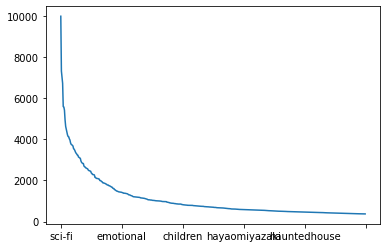

In [15]:
tags_df.drop(["user_id", "movie_id"], axis=1).sum().sort_values(ascending=False).plot()

In [16]:
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323783 entries, 0 to 323782
Columns: 502 entries, user_id to zombies
dtypes: int64(2), int8(500)
memory usage: 159.3 MB


In [17]:
del tags_vectors

### Обработка ratings.csv

In [18]:
ratings_df = pd.read_csv(f"{source_path}/ratings.csv")
ratings_df.sample(5)

,userId,movieId,rating,timestamp
19705110,201043,2011,3.0,942485498
17262939,176199,29,4.0,910240329
8638719,89092,805,3.5,1314537104
8806204,90866,337,4.0,837198499
21092105,215472,122882,5.0,1454447141


In [19]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753444 entries, 0 to 27753443
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 847.0 MB


In [20]:
ratings_df.rename({
    "movieId": "movie_id",
    "userId": "user_id"
}, axis=1, inplace=True)

In [21]:
ratings_df.drop("timestamp", axis=1, inplace=True)
ratings_df["rating"] = ratings_df["rating"].astype("int8")

In [22]:
ratings_df["rating_binary"] = (ratings_df["rating"] >= 4).astype("int8")
ratings_df.sample(5)

,user_id,movie_id,rating,rating_binary
163519,1628,1208,3,0
14908638,152446,370,4,1
875226,8795,33145,3,0
12913068,132177,1544,4,1
11541532,118292,2762,4,1


In [23]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753444 entries, 0 to 27753443
Data columns (total 4 columns):
 #   Column         Dtype
---  ------         -----
 0   user_id        int64
 1   movie_id       int64
 2   rating         int8 
 3   rating_binary  int8 
dtypes: int64(2), int8(2)
memory usage: 476.4 MB


# Подготовка данных для моделей

### Модель жанров

In [24]:
movies_ratings_df = pd.merge(
    ratings_df,
    movies_df,
    on="movie_id"
)

movies_ratings_df["views_count"] = movies_ratings_df.groupby('movie_id')["user_id"].transform('count')
movies_ratings_df["rating_mean"] = movies_ratings_df.groupby('movie_id')["rating"].transform('mean')

movies_ratings_df.sample(5)

,user_id,movie_id,rating,rating_binary,year,action,adventure,animation,children,comedy,...,imax,musical,mystery,romance,sci-fi,thriller,war,western,views_count,rating_mean
18097513,256023,1956,4,1,1980,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4771,3.805911
9391603,67394,4878,4,1,2001,0,0,0,0,0,...,0,0,1,0,1,1,0,0,28701,3.771437
25553818,251296,25940,4,1,1947,0,0,0,0,0,...,0,0,1,0,0,0,0,0,539,3.599258
21633157,248293,7150,4,1,2003,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1389,2.483081
25197089,92794,6777,3,0,1961,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1089,3.766758


In [25]:
users_genres_df = pd.concat([
    movies_ratings_df["user_id"].copy(),
    movies_ratings_df[genres_list].mul(movies_ratings_df["rating"], axis=0)
], axis=1)

users_genres_df[genres_list] = users_genres_df[genres_list].replace(0, None)
users_genres_df = users_genres_df.groupby("user_id")[genres_list].mean()
users_genres_df.sample(5)

,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,film-noir,horror,imax,musical,mystery,romance,sci-fi,thriller,war,western
user_id,,,,,,,,,,,,,,,,,,,
45671,2.929412,2.780488,2.5,3.0,3.206897,3.096774,3.0,3.051282,2.705882,4.0,3.219512,2.764706,3.0,3.5,3.00000,3.044776,3.089744,2.0,3.5
251801,4.250000,4.500000,4.0,4.0,4.000000,4.400000,NaN,4.500000,NaN,NaN,5.000000,4.000000,4.0,NaN,5.00000,3.000000,4.400000,5.0,5.0
158311,4.000000,3.000000,4.0,NaN,NaN,3.000000,NaN,1.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.333333,5.000000,2.0,NaN
216565,2.500000,2.666667,4.5,3.5,3.233333,3.800000,3.5,3.363636,3.600000,NaN,NaN,3.500000,4.0,3.5,3.37931,3.000000,2.833333,3.5,2.4
150335,4.479167,4.368421,5.0,NaN,4.000000,4.181818,NaN,4.148148,4.636364,NaN,4.888889,4.200000,NaN,4.2,4.00000,4.407407,4.400000,4.2,NaN


In [26]:
genres_model_df = pd.merge(
    movies_ratings_df[["user_id", "movie_id", "year", "rating", "rating_mean", "views_count"]],
    users_genres_df,
    on="user_id",
)

genres_model_df["rating_binary"] = (genres_model_df["rating"] >= 4).astype("int8")
genres_model_df.sample(5)

,user_id,movie_id,year,rating,rating_mean,views_count,action,adventure,animation,children,...,horror,imax,musical,mystery,romance,sci-fi,thriller,war,western,rating_binary
20122187,163467,115149,2014,2,3.543263,5351,2.781609,2.595745,3.105263,3.142857,...,3.596154,3.2,3.300000,3.657895,3.304878,2.911765,3.341040,2.923077,3.363636,0
5785445,112795,83613,2011,1,2.628304,2459,2.682672,2.731638,2.850467,2.881188,...,2.875000,2.5,2.833333,2.885057,2.910314,2.740876,2.748691,2.813953,2.793103,0
4669217,232491,3418,1991,3,3.455086,14138,3.272727,3.633333,4.100000,3.937500,...,3.000000,4.0,3.750000,2.666667,3.484848,3.324324,3.035088,3.833333,3.285714,0
27011472,211956,3623,2000,5,2.815831,21073,4.166667,4.333333,NaN,NaN,...,5.000000,NaN,NaN,NaN,3.000000,4.500000,4.500000,5.000000,5.000000,1
18611589,40822,1336,1991,3,2.243299,485,3.333333,3.000000,4.000000,4.000000,...,2.962791,NaN,4.500000,3.250000,3.000000,3.285714,3.088608,4.000000,5.000000,0


In [27]:
genres_model_df.isna().sum()

user_id                0
movie_id               0
year                   0
rating                 0
rating_mean            0
views_count            0
action            114503
adventure         145577
animation        1758101
children         1107787
comedy             58262
crime             286768
documentary      9456604
drama              21889
fantasy           571966
film-noir        8160034
horror           1514761
imax             4023094
musical          2575014
mystery           881093
romance           192395
sci-fi            320433
thriller          125084
war              1238659
western          3868185
rating_binary          0
dtype: int64

In [28]:
genres_model_df.dropna(axis=1, how="all", inplace=True)
genres_model_df.fillna(genres_model_df.median(), inplace=True)
genres_model_df.sample(5)

,user_id,movie_id,year,rating,rating_mean,views_count,action,adventure,animation,children,...,horror,imax,musical,mystery,romance,sci-fi,thriller,war,western,rating_binary
1688164,153610,171,1995,1,3.567235,1465,2.259740,2.280000,1.800000,1.826087,...,1.700000,3.500000,2.272727,3.000000,2.719512,2.290323,2.623529,2.333333,1.500000,0
10406421,188502,4973,2001,4,3.949794,37167,3.000000,2.916667,2.200000,2.200000,...,3.200000,3.428571,3.400000,3.555556,3.400000,3.125000,3.476190,3.200000,5.000000,1
12810682,13863,1270,1985,2,3.811017,57492,2.635945,2.874251,3.031250,2.593750,...,2.275862,2.949153,2.636364,2.794872,2.783333,2.669811,2.708333,3.068966,2.285714,0
24575032,143901,1376,1986,1,3.353148,15376,2.000000,1.750000,3.478261,3.311475,...,4.000000,3.428571,3.400000,1.000000,2.333333,2.000000,2.333333,1.000000,3.444444,0
3822261,108547,587,1990,4,3.360602,32210,3.533141,3.504545,3.789474,3.297297,...,3.500000,3.875000,3.818182,3.757576,3.402985,3.457565,3.583893,2.933333,3.636364,1


In [29]:
genres_model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27735055 entries, 0 to 27735054
Data columns (total 26 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        int64  
 1   movie_id       int64  
 2   year           int16  
 3   rating         int8   
 4   rating_mean    float64
 5   views_count    int64  
 6   action         float64
 7   adventure      float64
 8   animation      float64
 9   children       float64
 10  comedy         float64
 11  crime          float64
 12  documentary    float64
 13  drama          float64
 14  fantasy        float64
 15  film-noir      float64
 16  horror         float64
 17  imax           float64
 18  musical        float64
 19  mystery        float64
 20  romance        float64
 21  sci-fi         float64
 22  thriller       float64
 23  war            float64
 24  western        float64
 25  rating_binary  int8   
dtypes: float64(20), int16(1), int64(3), int8(2)
memory usage: 5.1 GB


In [30]:
dtypes_df = genres_model_df.select_dtypes(["float64", "float32"])
genres_model_df[dtypes_df.columns] = dtypes_df.astype("float16")
genres_model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27735055 entries, 0 to 27735054
Data columns (total 26 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        int64  
 1   movie_id       int64  
 2   year           int16  
 3   rating         int8   
 4   rating_mean    float16
 5   views_count    int64  
 6   action         float16
 7   adventure      float16
 8   animation      float16
 9   children       float16
 10  comedy         float16
 11  crime          float16
 12  documentary    float16
 13  drama          float16
 14  fantasy        float16
 15  film-noir      float16
 16  horror         float16
 17  imax           float16
 18  musical        float16
 19  mystery        float16
 20  romance        float16
 21  sci-fi         float16
 22  thriller       float16
 23  war            float16
 24  western        float16
 25  rating_binary  int8   
dtypes: float16(20), int16(1), int64(3), int8(2)
memory usage: 2.0 GB


In [31]:
del movies_df, movies_ratings_df, users_genres_df

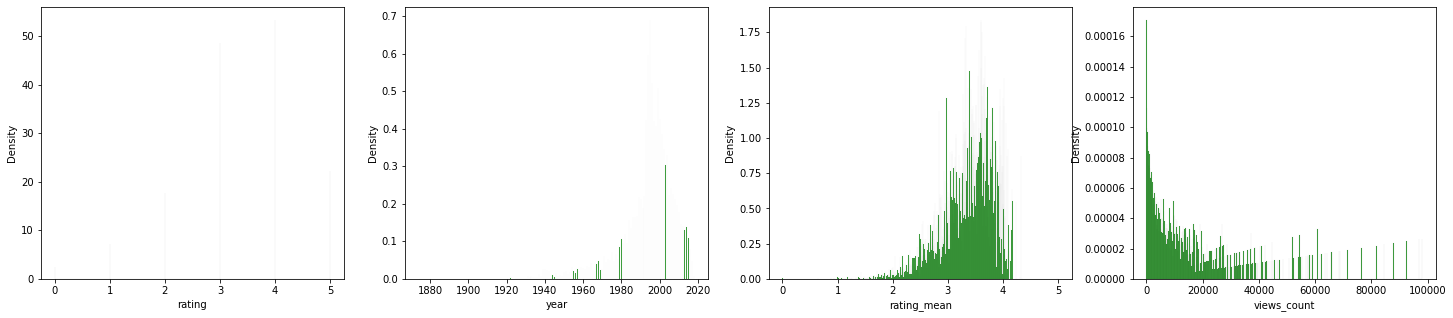

In [32]:
fig, ax = plt.subplots(1, 4, figsize=(25, 5))

for i, feature in enumerate(genres_model_df[["rating", "year", "rating_mean", "views_count"]]):
    sns.histplot(genres_model_df[feature], color="green", stat="density", ax=ax[i])

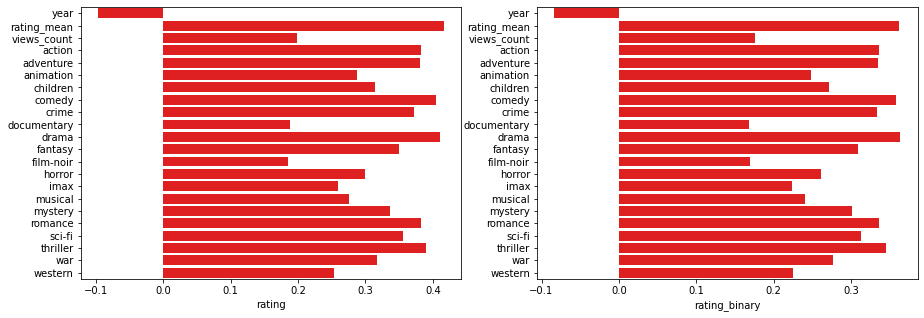

In [33]:
corr = genres_model_df.drop(["user_id", "movie_id"], axis=1).corr().drop(["rating", "rating_binary"])

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

for i, feature in enumerate(corr[["rating", "rating_binary"]]):
    sns.barplot(x=corr[feature], y=corr.index, orient="h", color="red", ax=ax[i])

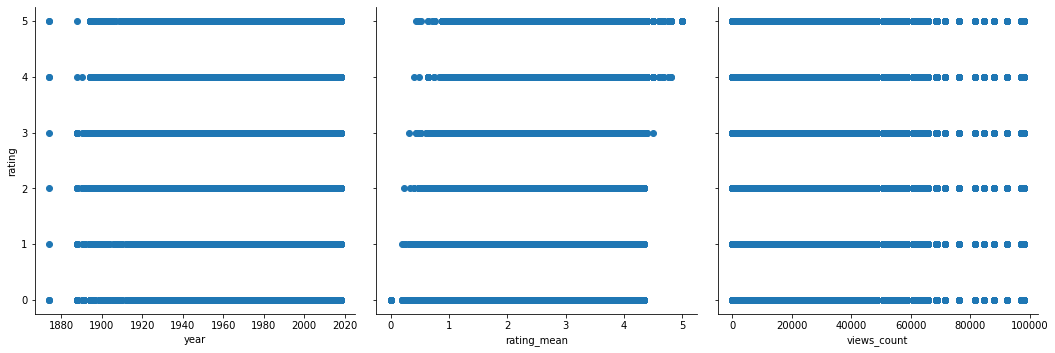

In [34]:
pg = sns.PairGrid(
    genres_model_df,
    x_vars=["year", "rating_mean", "views_count"],
    y_vars="rating",
    height=5,
)

pg.map(plt.scatter)

### Модель тэгов

In [35]:
tags_ratings_df = pd.merge(
    ratings_df.set_index(["user_id", "movie_id"]),
    tags_df.set_index(["user_id", "movie_id"]),
    on=["user_id", "movie_id"]
).reset_index()

tags_ratings_df.sample(5)

,user_id,movie_id,rating,rating_binary,10,11,1960s,1970s,1980s,19thcentury,...,willsmith,witch,witty,womandirector,women,woodyallen,worldwarii,writer,zombie,zombies
205271,263860,2457,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
131383,163374,541,5,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
46009,60651,6942,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25246,33852,56174,5,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
20020,27465,1375,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
users_tags_df = pd.concat([
    tags_ratings_df["user_id"].copy(),
    tags_ratings_df[tags_list].mul(tags_ratings_df["rating"], axis=0)
], axis=1)

users_tags_df.replace(0, None, inplace=True)
users_tags_df = users_tags_df.groupby("user_id")[tags_list].mean()
users_tags_df.sample(5)

,10,11,1960s,1970s,1980s,19thcentury,3d,70mm,absurd,acting,...,willsmith,witch,witty,womandirector,women,woodyallen,worldwarii,writer,zombie,zombies
user_id,,,,,,,,,,,,,,,,,,,,,
43540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197792,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
277877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
216610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
tags_model_df = pd.merge(
    tags_ratings_df[["user_id", "movie_id", "rating", "rating_binary"]],
    users_tags_df,
    on="user_id"
)
tags_model_df.sample(5)

,user_id,movie_id,rating,rating_binary,10,11,1960s,1970s,1980s,19thcentury,...,willsmith,witch,witty,womandirector,women,woodyallen,worldwarii,writer,zombie,zombies
136055,169556,593,4,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27093,36523,5618,4,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
164826,197461,25771,3,0,NaN,NaN,3.857143,3.666667,4.0,4.0,...,3.285714,NaN,NaN,NaN,NaN,3.5,3.857143,4.0,NaN,3.0
175982,215208,3148,5,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108336,136753,2571,3,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
tags_model_df.dropna(axis=1, how="all", inplace=True)
tags_model_df.fillna(tags_model_df.median(), inplace=True)
tags_model_df.sample(5)

,user_id,movie_id,rating,rating_binary,10,11,1960s,1970s,1980s,19thcentury,...,willsmith,witch,witty,womandirector,women,woodyallen,worldwarii,writer,zombie,zombies
160934,195628,26344,3,0,4.0,3.666667,3.454545,3.5,3.600000,3.666667,...,3.0,3.0,4.0,3.0,3.0,2.736842,3.8,3.153846,3.0,3.25
212076,273143,174055,5,1,4.0,3.666667,3.454545,3.5,3.600000,3.666667,...,3.0,3.0,4.0,3.0,3.0,3.500000,5.0,3.153846,3.0,3.25
22550,29677,562,4,1,4.0,3.666667,3.454545,3.5,3.666667,3.500000,...,3.0,3.0,4.0,3.0,2.5,4.000000,3.0,3.153846,3.0,3.25
131960,163965,48516,4,1,4.0,3.666667,3.454545,3.5,3.600000,3.666667,...,3.0,3.0,4.0,3.0,3.0,3.500000,3.8,3.153846,3.0,3.25
157166,194079,3247,5,1,4.0,3.666667,3.454545,3.5,3.600000,3.666667,...,2.5,3.0,4.0,3.0,3.0,3.500000,3.8,3.153846,3.0,3.25


In [40]:
tags_model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220232 entries, 0 to 220231
Columns: 504 entries, user_id to zombies
dtypes: float64(500), int64(2), int8(2)
memory usage: 845.6 MB


In [41]:
dtypes_df = tags_model_df.select_dtypes(["float64", "float32"])
tags_model_df[dtypes_df.columns] = dtypes_df.astype("float16")
tags_model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220232 entries, 0 to 220231
Columns: 504 entries, user_id to zombies
dtypes: float16(500), int64(2), int8(2)
memory usage: 215.5 MB


In [42]:
del tags_df, tags_ratings_df, users_tags_df

<AxesSubplot:xlabel='rating', ylabel='Density'>

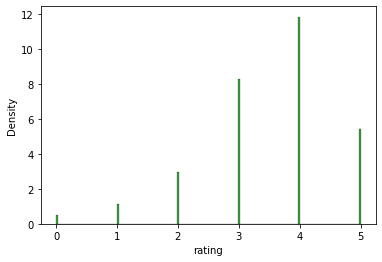

In [43]:
sns.histplot(tags_model_df["rating"], color="green", stat="density")

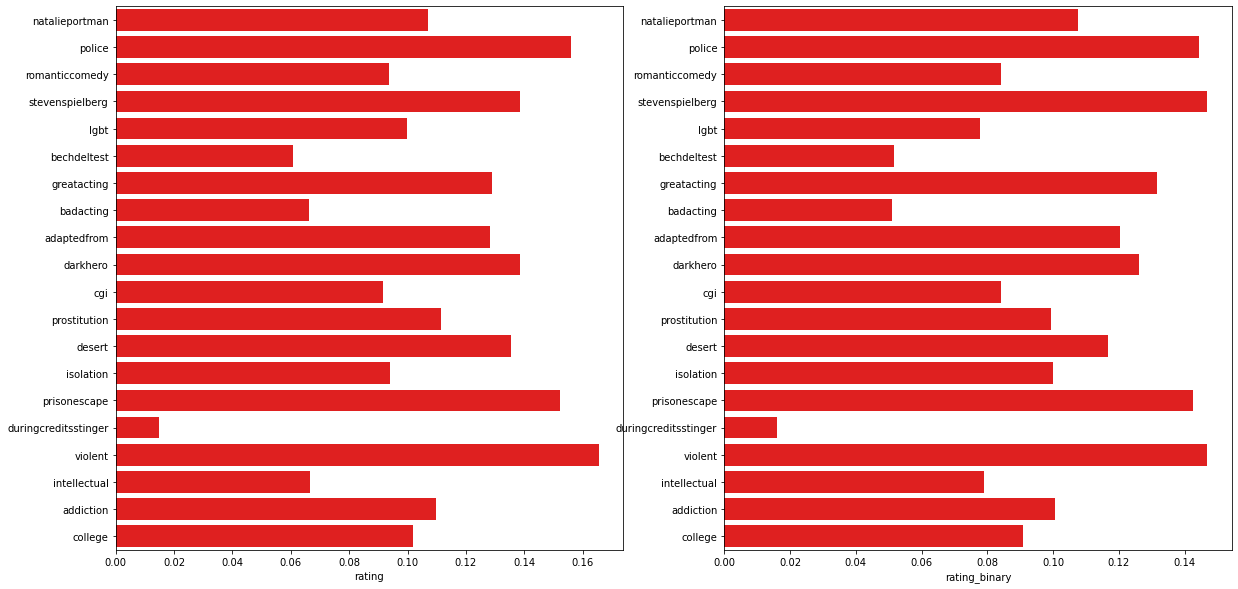

In [44]:
corr = tags_model_df.drop(["user_id", "movie_id"], axis=1).corr().drop(["rating", "rating_binary"]).sample(20)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

for i, feature in enumerate(corr[["rating", "rating_binary"]]):
    sns.barplot(x=corr[feature], y=corr.index, orient="h", color="red", ax=ax[i])

## Финальная модель

In [45]:
genres_model_renamed_df = genres_model_df.add_suffix("_genres")
tags_model_renamed_df = tags_model_df.add_suffix("_tags")

final_model_df = pd.merge(
    genres_model_renamed_df.set_index(["user_id_genres", "movie_id_genres"]),
    tags_model_renamed_df.set_index(["user_id_tags", "movie_id_tags"]),
    left_on=["user_id_genres", "movie_id_genres"],
    right_on=["user_id_tags", "movie_id_tags"],
)

final_model_df.sample(5)

,year_genres,rating_genres,rating_mean_genres,views_count_genres,action_genres,adventure_genres,animation_genres,children_genres,comedy_genres,crime_genres,...,willsmith_tags,witch_tags,witty_tags,womandirector_tags,women_tags,woodyallen_tags,worldwarii_tags,writer_tags,zombie_tags,zombies_tags
3513,1996,4,3.492188,25884,3.099609,3.191406,3.382812,3.101562,3.283203,3.570312,...,3.0,3.000000,4.0,3.0,3.0,4.667969,3.800781,3.154297,3.0,3.250000
6700,2010,2,3.460938,747,3.046875,3.095703,3.273438,3.298828,2.982422,2.894531,...,3.0,3.000000,4.0,3.0,3.0,3.500000,3.800781,3.154297,3.0,3.250000
10270,2015,0,3.955078,68,2.871094,2.892578,2.894531,3.121094,2.611328,2.970703,...,3.0,2.599609,4.5,3.0,3.0,4.500000,3.363281,3.511719,3.0,2.666016
39699,1997,3,3.673828,12695,2.966797,3.013672,3.128906,2.923828,2.755859,2.923828,...,3.0,3.000000,4.0,3.0,3.0,3.500000,3.111328,3.154297,3.0,2.500000
31290,1985,4,3.240234,1377,3.078125,3.109375,3.091797,2.638672,3.355469,3.365234,...,3.0,3.000000,4.0,3.0,3.0,3.500000,3.800781,3.154297,4.0,4.000000


In [46]:
final_model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219475 entries, 0 to 219474
Columns: 526 entries, year_genres to zombies_tags
dtypes: float16(520), int16(1), int64(1), int8(4)
memory usage: 222.3 MB


# Моделирование

In [47]:
def display_report(y_test: np.ndarray, y_pred: np.ndarray):
    class_names = set(y_test)
    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names)
    plt.yticks(ticks, class_names)

    sns.heatmap(pd.DataFrame(
        metrics.confusion_matrix(y_test, y_pred)),
        annot=True)
    plt.ylabel('Действительные значения')
    plt.xlabel('Предсказанные значения')
    plt.show()

    print(metrics.classification_report(y_test, y_pred, zero_division=0))

In [48]:
genres_columns = genres_model_renamed_df.drop([
    "user_id_genres", "movie_id_genres", "rating_genres", "rating_binary_genres"
], axis=1).columns
tags_columns = tags_model_renamed_df.drop([
    "user_id_tags", "movie_id_tags", "rating_tags", "rating_binary_tags"
], axis=1).columns

genres_columns_nums = [genres_model_renamed_df.columns.get_loc(c) for c in genres_columns]
tags_columns_nums = [tags_model_renamed_df.columns.get_loc(c) for c in tags_columns]

x = final_model_df.drop([
    "rating_genres", "rating_binary_genres", "rating_tags", "rating_binary_tags"
], axis=1)
y_multi = final_model_df["rating_genres"]
y_binary = final_model_df["rating_binary_genres"]

In [49]:
del final_model_df, genres_model_renamed_df, tags_model_renamed_df, genres_model_df, tags_model_df

### Мультиклассовая модель

In [50]:
x_train, x_test, y_train, y_test = train_test_split(x, y_multi, test_size=0.2, stratify=y_multi)

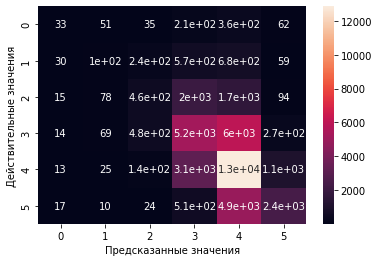

              precision    recall  f1-score   support

           0       0.27      0.04      0.08       746
           1       0.31      0.06      0.10      1687
           2       0.34      0.11      0.16      4285
           3       0.45      0.43      0.44     12051
           4       0.49      0.75      0.59     17244
           5       0.61      0.30      0.41      7882

    accuracy                           0.48     43895
   macro avg       0.41      0.28      0.30     43895
weighted avg       0.47      0.48      0.45     43895



In [51]:
pipe = Pipeline([
    ("scaling", MinMaxScaler()),
    ("normalizing", StandardScaler()),
    ("models", StackingClassifier([
        ("genres", Pipeline([
            ("extracting", ColumnSelector(genres_columns_nums)),
            ("rfc", RandomForestClassifier(max_depth=10, n_estimators=10, n_jobs=cpu_count())),
        ])),
        ("tags", Pipeline([
            ("extracting", ColumnSelector(tags_columns_nums)),
            ("dtc", DecisionTreeClassifier(max_depth=10))
        ]))
    ],
        LogisticRegression(C=10, max_iter=1e7, n_jobs=cpu_count()),
        n_jobs=cpu_count()
    ))
])

pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_test)
display_report(y_test, y_pred)

C:\Users\derbi\Projects\PyCharm\course-work\venv\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


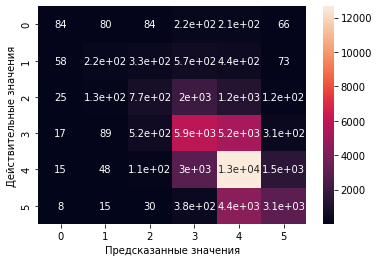

              precision    recall  f1-score   support

           0       0.41      0.11      0.18       746
           1       0.37      0.13      0.19      1687
           2       0.42      0.18      0.25      4285
           3       0.49      0.49      0.49     12051
           4       0.53      0.73      0.61     17244
           5       0.60      0.39      0.47      7882

    accuracy                           0.52     43895
   macro avg       0.47      0.34      0.37     43895
weighted avg       0.51      0.52      0.49     43895



In [52]:
pipe = Pipeline([
    ("mms", MinMaxScaler()),
    ("ss", StandardScaler()),
    ("sc", StackingClassifier([
        ("knc", KNeighborsClassifier(n_neighbors=50, n_jobs=cpu_count())),
        ("rfc", RandomForestClassifier(max_depth=10, n_estimators=10, n_jobs=cpu_count())),
        ("dtc", DecisionTreeClassifier(max_depth=10))
    ],
        LogisticRegression(max_iter=1e7, n_jobs=cpu_count()),
        n_jobs=cpu_count()
    ))
])

pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_test)
display_report(y_test, y_pred)

### Бинарная модель

In [53]:
x_train, x_test, y_train, y_test = train_test_split(x, y_binary, test_size=0.2, stratify=y_binary)

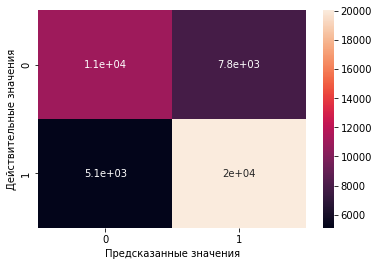

              precision    recall  f1-score   support

           0       0.68      0.58      0.63     18769
           1       0.72      0.80      0.76     25126

    accuracy                           0.71     43895
   macro avg       0.70      0.69      0.69     43895
weighted avg       0.70      0.71      0.70     43895



In [54]:
pipe = Pipeline([
    ("scaling", MinMaxScaler()),
    ("normalizing", StandardScaler()),
    ("models", StackingClassifier([
        ("genres", Pipeline([
            ("extracting", ColumnSelector(genres_columns_nums)),
            ("rfc", RandomForestClassifier(max_depth=10, n_estimators=10, n_jobs=cpu_count())),
        ])),
        ("tags", Pipeline([
            ("extracting", ColumnSelector(tags_columns_nums)),
            ("dtc", DecisionTreeClassifier(max_depth=10))
        ]))
    ],
        LogisticRegression(C=10, max_iter=1e7, n_jobs=cpu_count()),
        n_jobs=cpu_count()
    ))
])

pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_test)
display_report(y_test, y_pred)

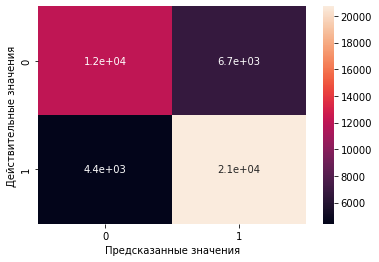

              precision    recall  f1-score   support

           0       0.73      0.64      0.68     18769
           1       0.76      0.82      0.79     25126

    accuracy                           0.75     43895
   macro avg       0.74      0.73      0.74     43895
weighted avg       0.75      0.75      0.74     43895



In [55]:
pipe = Pipeline([
    ("mms", MinMaxScaler()),
    ("ss", StandardScaler()),
    ("sc", StackingClassifier([
        ("knc", KNeighborsClassifier(n_neighbors=50, n_jobs=cpu_count())),
        ("rfc", RandomForestClassifier(max_depth=10, n_estimators=10, n_jobs=cpu_count())),
        ("dtc", DecisionTreeClassifier(max_depth=10))
    ],
        LogisticRegression(max_iter=1e7, n_jobs=cpu_count()),
        n_jobs=cpu_count()
    ))
])

pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_test)
display_report(y_test, y_pred)